In [67]:
from preprocessing import * 
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

from scipy.signal import butter, sosfilt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def filter(signal, band, fs):
  sos = butter(20, band, 'bandpass', fs=fs, output='sos')
  filtered = sosfilt(sos, signal)
  return filtered

In [69]:
filename = "data/A01T.gdf"
data = mne.io.read_raw_gdf(filename)


Extracting EDF parameters from d:\Study\GP\EEG-Motor-Imagery-classifier\data\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


c:\Users\Mohamad Abo Bakr\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\Users\Mohamad Abo Bakr\AppData\Local\Programs\Python\Python39\lib\contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [70]:
dataframe = data.to_data_frame()
dataframe = dataframe.drop(columns="time")


In [72]:
values = dataframe.values.T

filtered_eeg = np.zeros((9, *values.shape))

for i in range(1, 10):
  filtered_eeg[i-1] = filter(values, [4 * i, 4 * i + 4], 250)

print(filtered_eeg.shape)


(9, 25, 672528)


In [41]:
i = 1
x, y = read_file(i)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 100, test_size = 0.2)


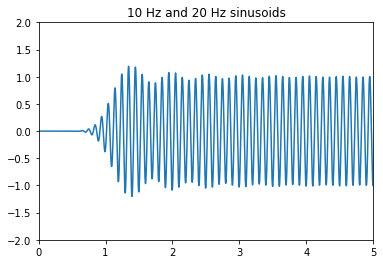

In [42]:
filter(sig, [8,12], 1000)